# Analyze Health Data

-----

## Backlog


- add vertical lines to mark surgery & novo start dates
- bar charts with steps/workouts side by side
- Build model of steps per mile
- ideally create single merged data table of daily fitness stats
- Workout data
- calories
- Mindfulness
- VO2max
- Integrate w/strava
- Need strava data to get calories from cycling workouts I think.

## Dependencies and Libraries

In [1]:
from datetime import date, datetime, timedelta as td
import pytz
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
%matplotlib inline

## Data Extraction

In [2]:
%run -i 'apple-health-data-parser' 'data/export.xml'

Reading data from data/export.xml . . . done


apple-health-data-parser.py:136: DeprecationWarning: This method will be removed in future versions.  Use 'list(elem)' or iteration over elem instead.
  self.nodes = self.root.getchildren()


Unexpected node of type ExportDate.

Tags:
ActivitySummary: 680
ExportDate: 1
Me: 1
Record: 1297939
Workout: 246

Fields:
HKCharacteristicTypeIdentifierBiologicalSex: 1
HKCharacteristicTypeIdentifierBloodType: 1
HKCharacteristicTypeIdentifierDateOfBirth: 1
HKCharacteristicTypeIdentifierFitzpatrickSkinType: 1
activeEnergyBurned: 680
activeEnergyBurnedGoal: 680
activeEnergyBurnedUnit: 680
appleExerciseTime: 680
appleExerciseTimeGoal: 680
appleStandHours: 680
appleStandHoursGoal: 680
creationDate: 1298185
dateComponents: 680
device: 1283003
duration: 246
durationUnit: 246
endDate: 1298185
sourceName: 1298185
sourceVersion: 1293544
startDate: 1298185
totalDistance: 246
totalDistanceUnit: 246
totalEnergyBurned: 246
totalEnergyBurnedUnit: 246
type: 1297939
unit: 1286773
value: 1297686
workoutActivityType: 246

Record types:
ActiveEnergyBurned: 611462
AppleExerciseTime: 23194
AppleStandHour: 10910
AppleStandTime: 4705
AudioExposureEvent: 2
BasalEnergyBurned: 186522
BodyMass: 327
DietaryCalciu

------

## Steps

In [3]:
steps = pd.read_csv("data/StepCount.csv")
# steps.tail()

### Correct time zone to EST and capture time properties

In [4]:
# parse out date and time elements as EST time
steps['startDate'] = pd.to_datetime(steps['startDate'], utc=True).dt.tz_convert('EST')
steps['endDate'] = pd.to_datetime(steps['endDate'], utc=True).dt.tz_convert('EST')
steps['date'] = steps['startDate'].dt.strftime('%Y-%m-%d')
steps['year_month'] = steps['startDate'].dt.strftime('%Y-%m')
steps['year'] = steps['startDate'].dt.year
steps['month'] = steps['startDate'].dt.month
steps['day'] = steps['startDate'].dt.day
steps['hour'] = steps['startDate'].dt.hour
steps['dow'] = steps['startDate'].dt.weekday
steps['doy'] = steps['startDate'].dt.dayofyear

#drop irrelevant columns
steps = steps.drop(['device', 'creationDate'], axis=1)
# steps.head()

### Use Only Watch Steps, Remove Phone Steps

In [5]:
# drop phone steps
steps = steps[steps.sourceName == 'Greg’s Apple\xa0Watch']
# steps.tail()

### Merge Fitbit data

In [6]:
# Read fitbit csv
fb = pd.read_csv('data/fitbit_master.csv')

# parse out date and time elements as EST time
fb['Date'] = pd.to_datetime(fb['Date'])#.dt.tz_convert('EST')
fb['date'] = fb['Date'].dt.strftime('%Y-%m-%d')
fb['year_month'] = fb['Date'].dt.strftime('%Y-%m')
fb['year'] = fb['Date'].dt.year
fb['month'] = fb['Date'].dt.month
fb['day'] = fb['Date'].dt.day
fb['dow'] = fb['Date'].dt.weekday
fb['doy'] = fb['Date'].dt.dayofyear

# #drop irrelevant columns
# fb = fb.drop(['Date', 'Calories Burned', 'Distance', 'Floors', 'Minutes Sedentary', 'Minutes Lightly Active', 'Minutes Fairly Active', 'Minutes Very Active','Activity Calories'], axis=1)

fb2=fb[['date', 'Steps']]
#drop rows that overlap apple watch
fb2=fb2.iloc[:-2,:]

# fb.head()
# fb2.tail()

-----

## Merge Fitbit Data

In [7]:
# Aggregate apple watch data by date
steps_by_date = steps.groupby(['date'])['value'].sum().reset_index(name='Steps')

#merge with fitbit data
steps_by_date = pd.concat([fb2, steps_by_date], ignore_index=True)

# print(steps_by_date.head())
print(steps_by_date.tail())

            date  Steps
1262  2020-04-17  21396
1263  2020-04-18  12041
1264  2020-04-19  13421
1265  2020-04-20  14571
1266  2020-04-21  15962


### Rolling average

In [49]:
steps_by_date2=steps_by_date.copy()
steps_by_date2['RollingMeanSteps'] = steps_by_date2.Steps.rolling(window=7, center=True).mean()

# steps_by_date2=steps_by_date2.dropna(axis=0)
steps_by_date2['date']=pd.to_datetime(steps_by_date2['date'])

steps_by_date2=steps_by_date2.set_index('date')

# print(steps_by_date2.head())
print(steps_by_date2.tail(20))

            Steps  RollingMeanSteps
date                               
2020-04-02   2626       3459.857143
2020-04-03   4811       3463.428571
2020-04-04   3476       4443.428571
2020-04-05   7168       4946.714286
2020-04-06   2289       5010.857143
2020-04-07   8425       4930.285714
2020-04-08   5832       6237.285714
2020-04-09   3075       6135.857143
2020-04-10   4247       6897.714286
2020-04-11  12625       8120.142857
2020-04-12   6458       7999.571429
2020-04-13   7622       9400.857143
2020-04-14  16982      11850.714286
2020-04-15   4988      11767.285714
2020-04-16  12884      12762.000000
2020-04-17  21396      13754.714286
2020-04-18  12041      13609.000000
2020-04-19  13421               NaN
2020-04-20  14571               NaN
2020-04-21  15962               NaN


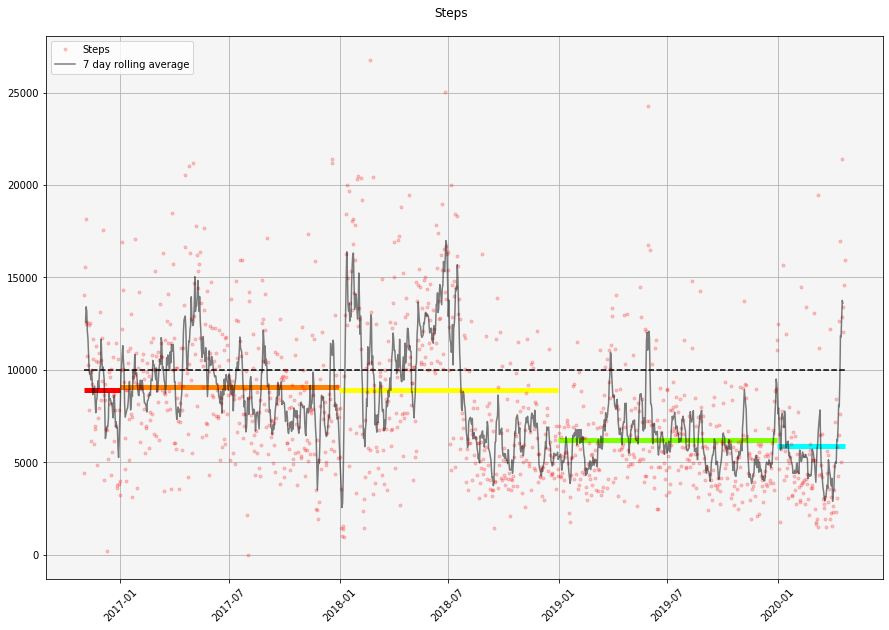

In [34]:
plt.figure(figsize=[15,10])
ax = plt.gca()
ax.set_facecolor('whitesmoke')
plt.suptitle('Steps', fontsize=12, y=.92)
plt.grid(True)
plt.plot(steps_by_date2['Steps'], 'r.', alpha=0.2,label='Steps')
plt.plot(steps_by_date2['RollingMeanSteps'], c='k',label='7 day rolling average', alpha=0.5)
plt.hlines(10000,steps_by_date2.index.min(), steps_by_date2.index.max(), linestyles='dashed')

plt.hlines(steps_by_date2.resample('Y').mean().iloc[0,0],steps_by_date2.index.min(), steps_by_date2.resample('Y').mean().index[0], colors=(1,0,0,1), linewidths=(5,))
plt.hlines(steps_by_date2.resample('Y').mean().iloc[1,0],steps_by_date2.resample('Y').mean().index[0], steps_by_date2.resample('Y').mean().index[1], colors=(1,0.5,0,1), linewidths=(5,))
plt.hlines(steps_by_date2.resample('Y').mean().iloc[2,0],steps_by_date2.resample('Y').mean().index[1], steps_by_date2.resample('Y').mean().index[2], colors=(1,1,0,1), linewidths=(5,))
plt.hlines(steps_by_date2.resample('Y').mean().iloc[3,0],steps_by_date2.resample('Y').mean().index[2], steps_by_date2.resample('Y').mean().index[3], colors=(0.5,1,0,1), linewidths=(5,))
plt.hlines(steps_by_date2.resample('Y').mean().iloc[4,0],steps_by_date2.resample('Y').mean().index[3], steps_by_date2.index.max(), colors=(0,1,1,1), linewidths=(5,))

plt.legend(loc=2)
plt.xticks(rotation=45)

plt.show()

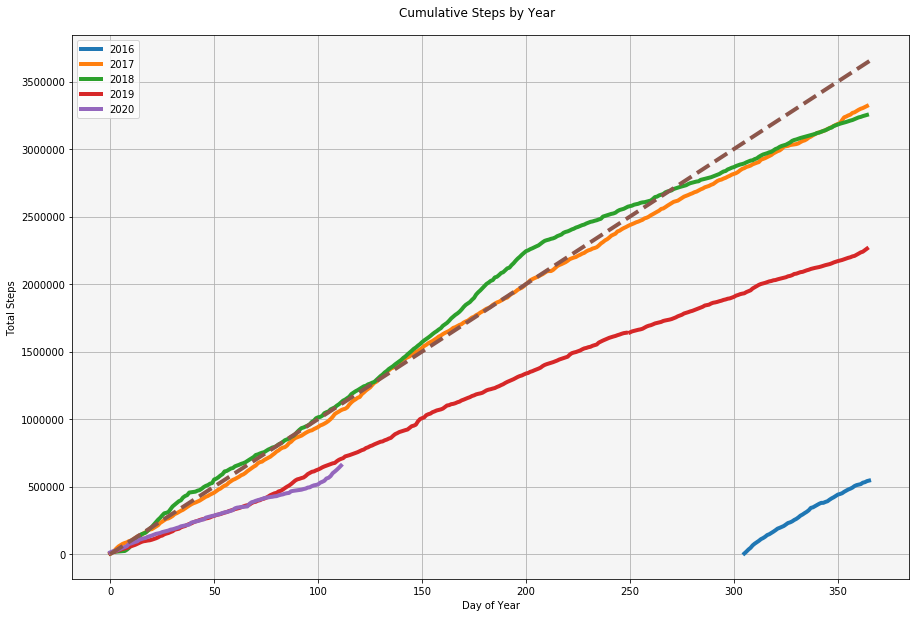

In [35]:
df = steps_by_date.copy()
df['date'] = pd.to_datetime(df['date'])
df['year'] = df['date'].dt.year
df['doy'] = df['date'].dt.dayofyear

steps_by_year = pd.pivot_table(df, index='doy', columns='year', values='Steps', aggfunc='sum').reset_index().rename_axis(None, axis=1)

plt.figure(figsize=[15,10])
ax = plt.gca()
ax.set_facecolor('whitesmoke')
plt.suptitle('Cumulative Steps by Year', fontsize=12, y=.92)
plt.grid(True)
plt.plot(steps_by_year[2016].cumsum(), label='2016', linewidth=4)
plt.plot(steps_by_year[2017].cumsum(), label='2017', linewidth=4)
plt.plot(steps_by_year[2018].cumsum(), label='2018', linewidth=4)
plt.plot(steps_by_year[2019].cumsum(), label='2019', linewidth=4)
plt.plot(steps_by_year[2020].cumsum(), label='2020', linewidth=4)

x1, y1 = [0,366], [0,3660000]
plt.plot(x1,y1, linewidth = 4, linestyle='dashed')

plt.ylabel("Total Steps")
plt.xlabel("Day of Year")
plt.legend(loc=2)
# plt.xticks(rotation=45)

plt.show()

In [42]:
### Steps needed to get on track

#Yearly averages
yearly_totals = steps_by_date.copy()
yearly_totals['date']=pd.to_datetime(yearly_totals['date'])
yearly_totals=yearly_totals.set_index('date')
yearly_totals =yearly_totals['Steps'].resample('Y').sum()
print(yearly_totals)

#Current DOY
doy = datetime.today().timetuple().tm_yday#.strftime('%Y-%m-%d')

print("Today is the {}th day of {}.".format(doy, yearly_totals.index[-1].year))
# print("Every {} extra steps today raises my yearly average by 1 step".format((365-doy)))
print("Every {} extra steps today makes up for 1 step on my average for the year so far".format(math.ceil(doy-1)))
print("I am currently averaging {} steps per day for {}.".format(math.ceil(yearly_totals.iloc[-1]/doy), yearly_totals.index[-1].year))
print("I am {} steps behind what I need to be at a 10,000 steps per day average.".format((doy*10000-yearly_totals.iloc[-1])))
print("This is equivalent to being {} days behind".format(round((doy*10000-yearly_totals.iloc[-1])/10000, 1)))
print("To reach 10,000 steps per day I will need to walk", math.ceil((3652500-yearly_totals.iloc[-1])/(365.25-doy)), "steps per day for the rest of the year.")
print("To beat my", yearly_totals.index[1].year,"total I will need to walk", math.ceil((yearly_totals.iloc[1]-yearly_totals.iloc[-1])/(365.25-doy)), "steps per day for the rest of the year.")
print("To beat my", yearly_totals.index[2].year,"total I will need to walk", math.ceil((yearly_totals.iloc[2]-yearly_totals.iloc[-1])/(365.25-doy)), "steps per day for the rest of the year.")
print("To beat my", yearly_totals.index[3].year,"total I will need to walk", math.ceil((yearly_totals.iloc[3]-yearly_totals.iloc[-1])/(365.25-doy)), "steps per day for the rest of the year.")

date
2016-12-31     544418
2017-12-31    3318765
2018-12-31    3252673
2019-12-31    2262489
2020-12-31     655353
Freq: A-DEC, Name: Steps, dtype: int64
Today is the 112th day of 2020.
Every 111 extra steps today makes up for 1 step on my average for the year so far
I am currently averaging 5852 steps per day for 2020.
I am 464647 steps behind what I need to be at a 10,000 steps per day average.
This is equivalent to being 46.5 days behind
To reach 10,000 steps per day I will need to walk 11835 steps per day for the rest of the year.
To beat my 2017 total I will need to walk 10517 steps per day for the rest of the year.
To beat my 2018 total I will need to walk 10256 steps per day for the rest of the year.
To beat my 2019 total I will need to walk 6347 steps per day for the rest of the year.


In [37]:
# #Write df to csv
# steps_by_date.to_csv("data/steps_per_day.csv", index=False)

------

## Monthly Steps

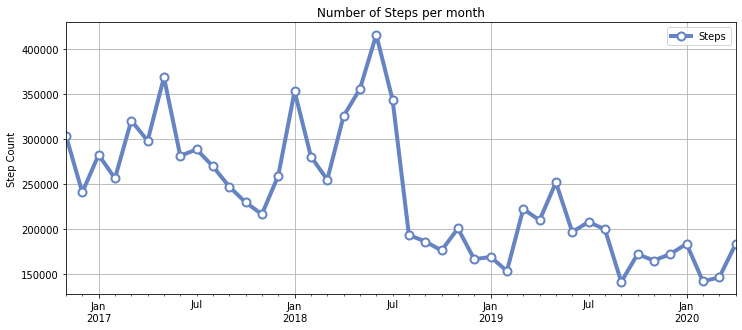

415861

In [38]:
df = steps_by_date.copy()
df['date'] = pd.to_datetime(df['date'])
df=df.set_index('date')
df = df.resample('M').sum()
# df.head()

chart_title = 'Number of Steps per month'

ax = df.plot(kind='line', figsize=[12, 5], linewidth=4, alpha=1, marker='o', color='#6684c1', 
                      markeredgecolor='#6684c1', markerfacecolor='w', markersize=8, markeredgewidth=2)

ax.yaxis.grid(True)
ax.xaxis.grid(True)
ax.set_ylabel('Step Count')
ax.set_xlabel('')
ax.set_title(chart_title)

plt.show()
df.Steps.max()

## Steps By Year

year
2016    303611.0
2017    368655.0
2018    415861.0
2019    251924.0
2020    183713.0
dtype: float64


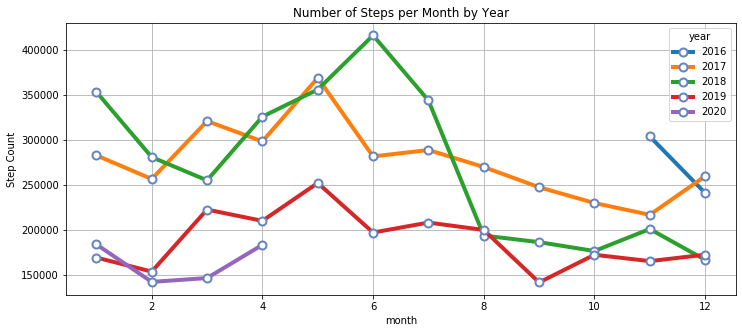

In [46]:
# Group data by year in pivot table
df2 = steps_by_date.copy()
df2['date'] = pd.to_datetime(df2['date'])
df2['year'] = df2['date'].dt.year
df2['month'] = df2['date'].dt.month

df3 = pd.pivot_table(df2, index='month', columns='year', values='Steps', aggfunc='sum')
chart_title = 'Number of Steps per Month by Year'

ax = df3.plot(kind='line', figsize=[12, 5], linewidth=4, alpha=1, marker='o', 
                      markeredgecolor='#6684c1', markerfacecolor='w', markersize=8, markeredgewidth=2)

ax.yaxis.grid(True)
ax.xaxis.grid(True)
ax.set_ylabel('Step Count')
ax.set_title(chart_title)

print(df3.max())
# print(df3.head())

plt.show()

----

-----

## Weight Data

In [40]:
#import apple data
weight = pd.read_csv("data/BodyMass.csv")
#keep only apple health data (the rest are copies)
weight = weight[weight.sourceName=='Health']
#sort and reindex
weight = weight.sort_values(by='startDate', ignore_index=True)

# parse out date and time elements as EST time
weight['startDate'] = pd.to_datetime(weight['startDate'], utc=True).dt.tz_convert('EST')
weight['endDate'] = pd.to_datetime(weight['endDate'], utc=True).dt.tz_convert('EST')
weight['date'] = weight['startDate'].dt.strftime('%Y-%m-%d')

# drop duplicates
weight.drop_duplicates(subset = 'date', keep='last', ignore_index=True, inplace=True)

#drop irrelevant columns and rename value to Weight
weight = weight[['value','date']]
weight.rename(columns={'value':'Weight'}, inplace=True)

# weight.head(10)

In [16]:
#import fitbit weight data
weight2 = pd.read_csv("data/fitbit_weight.csv")

weight2['Date'] = pd.to_datetime(weight2['Date'])
weight2['date'] = weight2['Date'].dt.strftime('%Y-%m-%d')
weight2 = weight2.drop(['Date','BMI'], axis=1)

# weight2.head(10)

In [17]:
#merge with fitbit data
# print(weight.shape)
weight = pd.concat([weight2,weight], ignore_index=True)
# print(weight.shape)
# weight.tail()

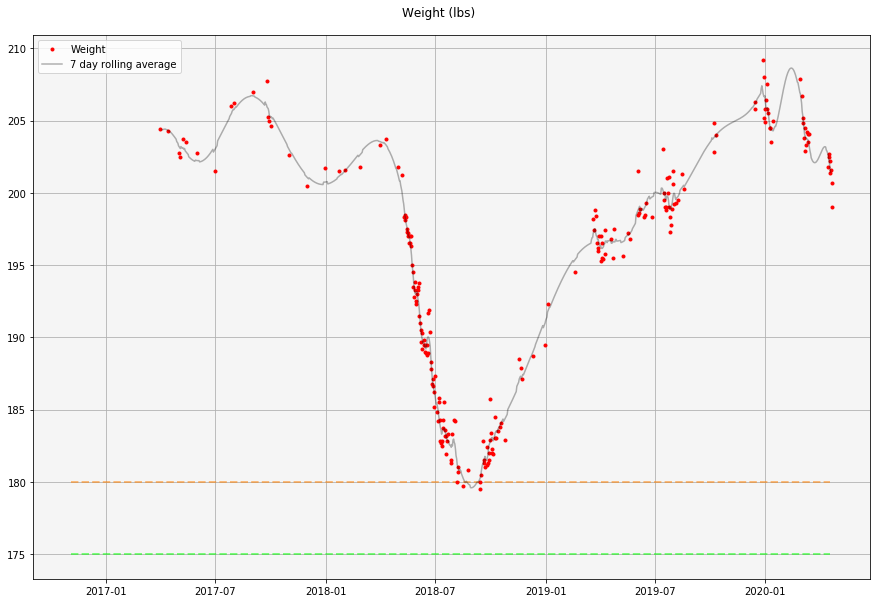

In [18]:
# parse out date and time elements
weight3 =weight.copy()
weight3['Date'] = pd.to_datetime(weight3['date'])

#sort by date and reindex
weight3 = weight3.sort_values(by='Date', ignore_index=True)

#set Date as index
weight3 = weight3.drop('date', axis=1).set_index('Date')

#resample by day and interpolate missing values using splines
weight4 = weight3.resample('D').interpolate(method='spline', order = 4, axis = 0)
# print(weight3.shape)

#create a 7day rolling average
weight4['rolling_avg']=weight4.rolling(window=7, center=True).mean()

#plot it
plt.figure(figsize=[15,10])
ax = plt.gca()
ax.set_facecolor('whitesmoke')
plt.suptitle('Weight (lbs)', fontsize=12, y=.92)
plt.grid(True)
plt.plot(weight3['Weight'], 'r.', alpha=1,label='Weight')
plt.plot(weight4['rolling_avg'], c='k', alpha=0.3,label='7 day rolling average')

plt.hlines(180,steps_by_date2.index.min(), steps_by_date2.index.max(), linestyles='dashed', colors=(1,.5,0,0.5), linewidths=(2,))
plt.hlines(175,steps_by_date2.index.min(), steps_by_date2.index.max(), linestyles='dashed', colors=(0,1,0,0.5), linewidths=(2,))

plt.legend(loc=2)

plt.show()

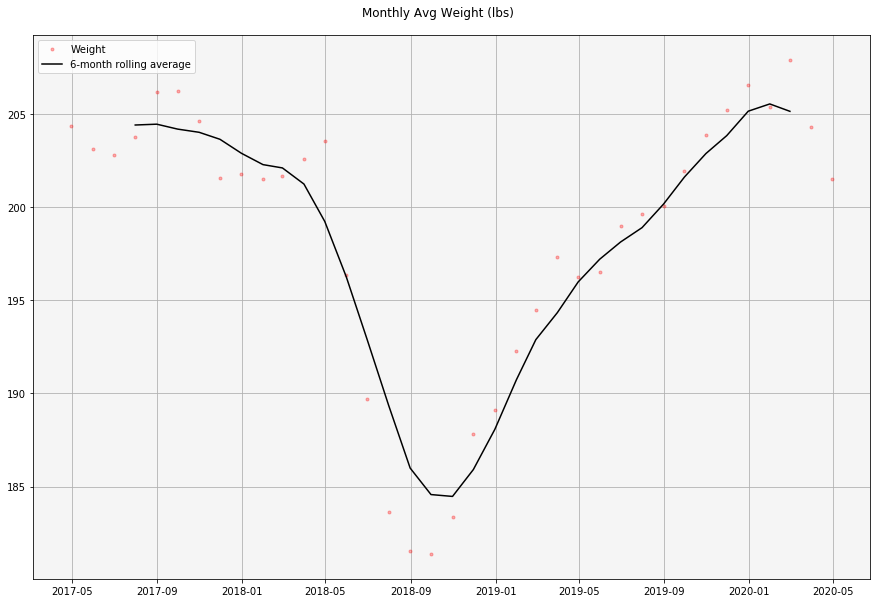

In [19]:
# parse out date and time elements
weight2 =weight.copy()
weight2['Date'] = pd.to_datetime(weight2['date'])

#sort by date and reindex
weight2 = weight2.sort_values(by='Date', ignore_index=True)

#set Date as index
weight2 = weight2.drop('date', axis=1).set_index('Date')

#resample by day and interpolate missing values using splines
weight2 = weight2.resample('M').mean().interpolate(method='linear', axis = 0)
# print(weight2.shape)

#create a 6-month rolling average
weight2['rolling_avg']=weight2.rolling(window=6, center=True).mean()

plt.figure(figsize=[15,10])
ax = plt.gca()
ax.set_facecolor('whitesmoke')
plt.suptitle('Monthly Avg Weight (lbs)', fontsize=12, y=.92)
plt.grid(True)
plt.plot(weight2['Weight'], 'r.', alpha=0.3,label='Weight')
plt.plot(weight2['rolling_avg'], c='k',label='6-month rolling average')
plt.legend(loc=2)
# plt.xticks(rotation=45)

plt.show()

## Heart Rate

----

### Resting Heart Rate

In [20]:
resting = pd.read_csv("data/RestingHeartRate.csv")
# print(resting.head())

# parse out date and time elements as EST time
resting['startDate'] = pd.to_datetime(resting['startDate'], utc=True).dt.tz_convert('EST')
resting['date'] = resting['startDate'].dt.strftime('%Y-%m-%d')

#Delete unnecessary columns
# resting = resting.drop(['sourceName', 'sourceVersion', 'device', 'type', 'unit', 'creationDate', 'startDate', 'endDate'], axis=1)
resting = resting[['date', 'value']]

print(resting.head())

         date  value
0  2018-06-17     59
1  2018-06-18     53
2  2018-06-19     57
3  2018-06-21     54
4  2018-06-20     57


In [21]:
#Creating daily average resting HR
resting_daily = resting.copy()
resting_daily = resting_daily.sort_values('date', ignore_index=True)
resting_daily = resting_daily.groupby(['date'])['value'].mean().reset_index(name='Resting_HR')
resting_daily['date'] = pd.to_datetime(resting_daily['date'])
resting_daily = resting_daily.set_index('date')
 
resting_daily = resting_daily.resample('D').interpolate(method='spline', order = 4, axis = 0)

print(resting_daily.head())

            Resting_HR
date                  
2018-06-17        59.0
2018-06-18        53.0
2018-06-19        57.0
2018-06-20        57.0
2018-06-21        54.0


In [22]:
#Add rolling average
resting_daily2 = resting_daily.copy()
resting_daily2['RollingHR_7'] = resting_daily2.Resting_HR.rolling(window=7, center = True).mean()
resting_daily2['RollingHR_30'] = resting_daily2.Resting_HR.rolling(window=30, center = True).mean()

resting_daily2 = resting_daily2.dropna(axis=0)

print(resting_daily2.head())

            Resting_HR  RollingHR_7  RollingHR_30
date                                             
2018-07-02        54.0    54.428571     54.892191
2018-07-03        51.0    55.428571     54.692191
2018-07-04        54.0    54.928571     54.758857
2018-07-05        55.0    54.726057     54.692191
2018-07-06        62.0    56.154628     54.592191


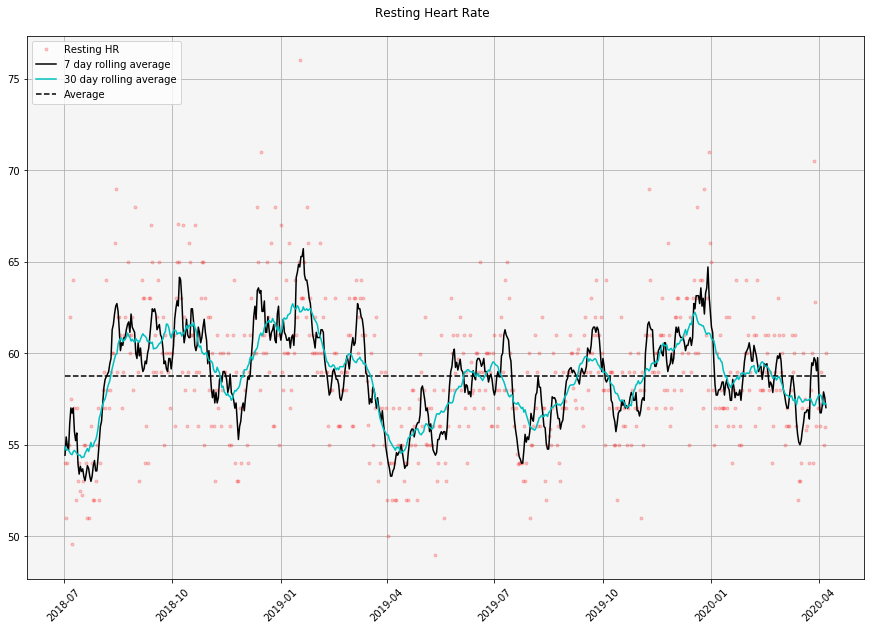

In [23]:
#plot resting HR with rolling avg
plt.figure(figsize=[15,10])
ax = plt.gca()
ax.set_facecolor('whitesmoke')
plt.suptitle('Resting Heart Rate', fontsize=12, y=.92)
plt.grid(True)
plt.plot(resting_daily2['Resting_HR'], 'r.', alpha=0.2,label='Resting HR')
plt.plot(resting_daily2['RollingHR_7'], c='k',label='7 day rolling average', alpha=1)
plt.plot(resting_daily2['RollingHR_30'], c='c',label='30 day rolling average', alpha=1)
plt.hlines(resting_daily2['Resting_HR'].mean(),resting_daily2.index.min(), resting_daily2.index.max(), label = 'Average', linestyles='dashed')

plt.legend(loc=2)
plt.xticks(rotation=45)

plt.show()

### Heart Rate

In [24]:
hr = pd.read_csv("data/HeartRate.csv")

# parse out date and time elements as EST time
hr['startDate'] = pd.to_datetime(hr['startDate'], utc=True).dt.tz_convert('EST')
# hr['date'] = hr['startDate'].dt.strftime('%Y-%m-%d')

#Delete unnecessary columns
hr = hr[['startDate', 'value']]

# hr.head()
# hr.tail()

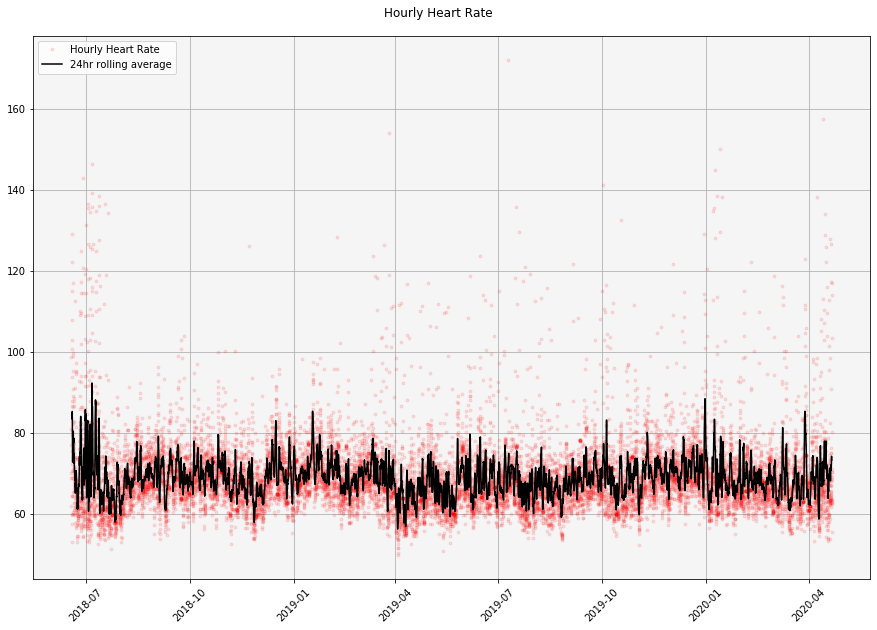

In [25]:
hr2 = hr.copy()
hr2 =hr2.sort_values('startDate', ignore_index=True)
hr2 = hr2.set_index('startDate')
hr2 = hr2.resample('H').mean()
hr2 = hr2.resample('H').interpolate(method='linear', axis = 0)

# print(hr2.head())

hr2['RollingHR'] = hr2.value.rolling(window=24, center = True).mean()

#plot resting HR with rolling avg
plt.figure(figsize=[15,10])
ax = plt.gca()
ax.set_facecolor('whitesmoke')

plt.suptitle('Hourly Heart Rate', fontsize=12, y=.92)
plt.grid(True)
plt.plot(hr2['value'], 'r.', alpha=0.1,label='Hourly Heart Rate')
plt.plot(hr2['RollingHR'], c='k',label='24hr rolling average', alpha=1)

plt.legend(loc=2)
plt.xticks(rotation=45)

plt.show()

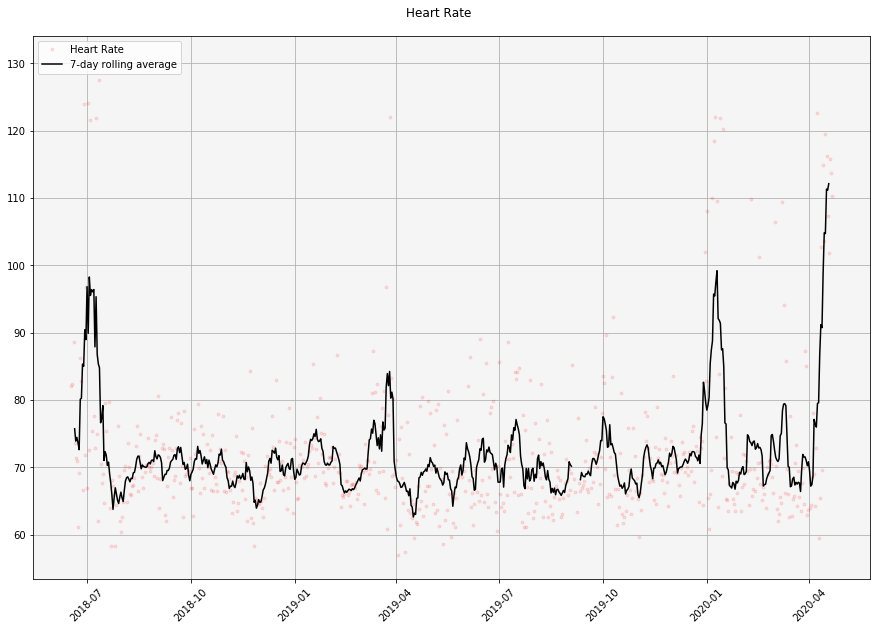

In [26]:
hr2 = hr.copy()
hr2 =hr2.sort_values('startDate', ignore_index=True)
hr2 = hr2.set_index('startDate')
hr2 = hr2.resample('D').mean()
# hr2 = hr2.resample('H').interpolate(method='linear', axis = 0)

# print(hr2.head())

hr2['RollingHR'] = hr2.value.rolling(window=7, center = True).mean()

#plot resting HR with rolling avg
plt.figure(figsize=[15,10])
ax = plt.gca()
ax.set_facecolor('whitesmoke')

plt.suptitle('Heart Rate', fontsize=12, y=.92)
plt.grid(True)
plt.plot(hr2['value'], 'r.', alpha=0.1,label='Heart Rate')
plt.plot(hr2['RollingHR'], c='k',label='7-day rolling average', alpha=1)

plt.legend(loc=2)
plt.xticks(rotation=45)

plt.show()

------

## Workout data 

In [27]:
Workout = pd.read_csv("data/Workout.csv")

# parse out date and time elements as EST time
Workout['startDate'] = pd.to_datetime(Workout['startDate'], utc=True).dt.tz_convert('EST')
Workout['endDate'] = pd.to_datetime(Workout['endDate'], utc=True).dt.tz_convert('EST')
Workout['date'] = Workout['startDate'].dt.strftime('%Y-%m-%d')

#Clean workout names
Workout['workoutActivityType'] = Workout['workoutActivityType'].str.replace('HKWorkoutActivityType','')

#round some feautures
Workout.duration = round(Workout.duration, 1)
Workout.totalEnergyBurned = round(Workout.totalEnergyBurned, 0)
Workout.totalDistance = round(Workout.totalDistance, 3)

#Delete unnecessary columns
Workout = Workout.drop(['sourceVersion', 'device', 'creationDate', 'durationUnit', 'totalDistanceUnit', 'totalEnergyBurnedUnit'], axis=1)

# Workout = Workout[['startDate', 'value']]

print(Workout.head(20))
# print(Workout.tail())
# print(Workout.shape)
# print(Workout.sourceName.unique())
# print(Workout.workoutActivityType.unique())

# print(Workout[Workout['sourceName']=='Strava'])


            sourceName                 startDate                   endDate  \
0   Greg’s Apple Watch 2018-06-17 19:35:27-05:00 2018-06-17 20:53:40-05:00   
1   Greg’s Apple Watch 2018-06-18 05:26:41-05:00 2018-06-18 06:25:12-05:00   
2   Greg’s Apple Watch 2018-06-18 19:34:24-05:00 2018-06-18 20:12:07-05:00   
3   Greg’s Apple Watch 2018-06-19 08:22:28-05:00 2018-06-19 08:42:41-05:00   
4   Greg’s Apple Watch 2018-06-19 13:09:58-05:00 2018-06-19 13:45:12-05:00   
5   Greg’s Apple Watch 2018-06-20 14:06:48-05:00 2018-06-20 15:16:20-05:00   
6   Greg’s Apple Watch 2018-06-21 19:27:20-05:00 2018-06-21 20:05:03-05:00   
7   Greg’s Apple Watch 2018-06-22 05:19:31-05:00 2018-06-22 06:29:26-05:00   
8   Greg’s Apple Watch 2018-06-23 13:51:09-05:00 2018-06-23 15:04:20-05:00   
9   Greg’s Apple Watch 2018-06-24 09:28:58-05:00 2018-06-24 10:59:55-05:00   
10              Strava 2018-06-25 05:30:39-05:00 2018-06-25 06:21:21-05:00   
11  Greg’s Apple Watch 2018-06-25 05:20:40-05:00 2018-06-25 06:2

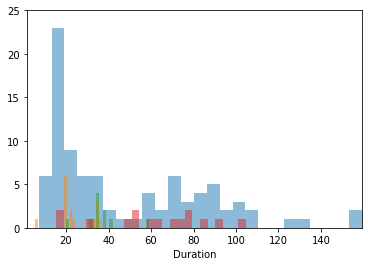

['Walking' 'Cycling' 'Tennis' 'Running' 'PaddleSports' 'Swimming' 'Yoga'
 'Elliptical' 'StairClimbing' 'Rowing' 'TraditionalStrengthTraining']


In [28]:
# #set seed
# random.seed(42)

#Specify distribution parameters
bn = 25

# mu1 = 14.5
# sig1 = 0.25

# mu2 = 14.5
# sig2=0.186

# #Create data
# x1 = np.random.normal(mu1, sig1, 500)
# x2 = np.random.normal(mu2, sig2, 500)


n, bins, patches = plt.hist(Workout.duration[Workout.workoutActivityType=='Walking'], bn, density=False, alpha =0.5)
n, bins, patches = plt.hist(Workout.duration[Workout.workoutActivityType=='Running'], bn, density=False, alpha =0.5)
n, bins, patches = plt.hist(Workout.duration[Workout.workoutActivityType=='Tennis'], bn, density=False, alpha =0.5)
n, bins, patches = plt.hist(Workout.duration[Workout.workoutActivityType=='Cycling'], bn, density=False, alpha =0.5)
# plt.plot(bins, norm.pdf(bins, mu1, sig1), 'c', linewidth=2)
# plt.axvline(x=mu1, linewidth=2, color='r')
plt.xlabel('Duration')
xmin, xmax, ymin, ymax = plt.axis()
plt.axis([Workout.duration.min(), Workout.duration.max(),0, 25])
# print(xmin)
# plt.show()

# n, bins, patches = plt.hist(x2, bn, density=True, facecolor='green', alpha =0.5)
# plt.plot(bins, norm.pdf(bins, mu2, sig2), 'g', linewidth=2)
# # plt.axvline(x=mu1, linewidth=2, color='r')
# plt.xlabel('Drop Ethanol')
# xmin2, xmax2, ymin2, ymax2 = plt.axis()
# plt.axis([xmin, xmax, 0,3.5])

# plt.grid(True)
plt.show()

# print(Workout.duration[Workout.workoutActivityType=='Walking'])
# print(Workout.duration.min())
# print(Workout.duration.max())
print(Workout.workoutActivityType.unique())


In [29]:
Workout2 = pd.pivot_table(Workout, index='date', columns='workoutActivityType', values='duration', aggfunc='sum').reset_index().rename_axis(None, axis=1)

# steps_by_year = pd.pivot_table(df, index='doy', columns='year', values='Steps', aggfunc='sum').reset_index().rename_axis(None, axis=1)

Workout2.head()


,date,Cycling,Elliptical,PaddleSports,Rowing,Running,StairClimbing,Swimming,Tennis,TraditionalStrengthTraining,Walking,Yoga
0,2018-06-17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,78.2,NaN
1,2018-06-18,58.5,NaN,NaN,NaN,NaN,NaN,NaN,37.7,NaN,NaN,NaN
2,2018-06-19,NaN,NaN,NaN,NaN,20.2,NaN,NaN,35.2,NaN,NaN,NaN
3,2018-06-20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,69.5,NaN
4,2018-06-21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,37.7,NaN,NaN,NaN


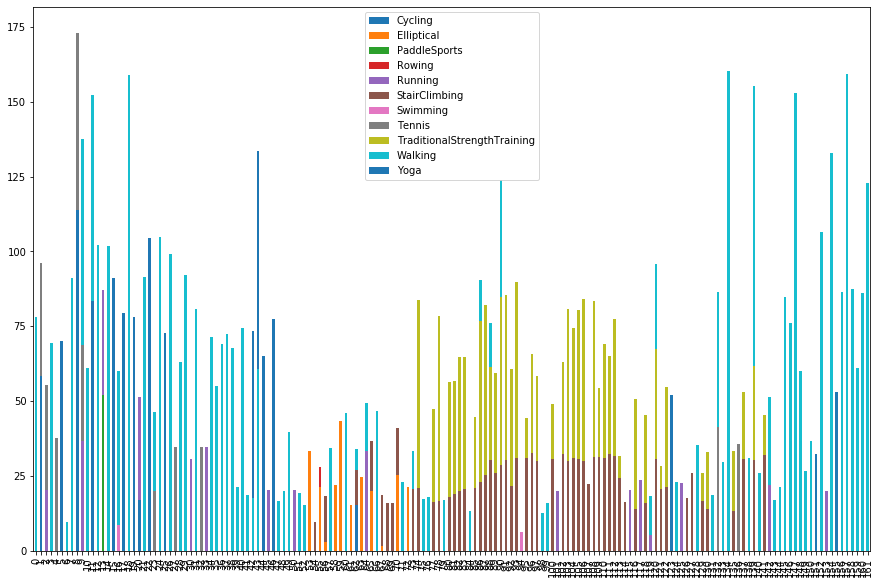

In [30]:
# pivot_df.loc[:,['Jan','Feb', 'Mar']].plot.bar(stacked=True, color=colors, figsize=(10,7))

Workout2.plot.bar(stacked=True, figsize=(15,10))


In [31]:
Workout3 = Workout.copy()
Workout3['steps'] = np.nan

for index, row in Workout3.iterrows():
    x = steps[(steps.startDate>=Workout3.startDate[index]) & (steps.endDate<=Workout3.endDate[index])]
    Workout3.steps[index] = x.value.sum()
    
Workout3['Steps_perMile'] = Workout3.steps/Workout3.totalDistance


# print(Workout3.iloc[0])
# x = steps[(steps.startDate>=Workout3.startDate[0]) & (steps.endDate<=Workout3.endDate[0])]# & steps[steps.endDate<=Workout3.endDate[0]]
# x = x[x.endDate<=Workout3.endDate[0]]


# print(steps.head())
# print(Workout3.head(25))
print(Workout3.tail(25))
# print(x)
# print('steps =',x.value.sum())

apple-health-data-parser.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


             sourceName                 startDate                   endDate  \
221  Greg’s Apple Watch 2020-01-13 18:10:35-05:00 2020-01-13 18:23:53-05:00   
222              Strava 2020-01-15 11:00:44-05:00 2020-01-15 11:22:35-05:00   
223  Greg’s Apple Watch 2020-01-15 11:23:25-05:00 2020-01-15 11:52:59-05:00   
224  Greg’s Apple Watch 2020-01-17 17:46:46-05:00 2020-01-17 18:03:53-05:00   
225  Greg’s Apple Watch 2020-02-02 08:47:08-05:00 2020-02-02 09:08:23-05:00   
226  Greg’s Apple Watch 2020-02-09 16:28:39-05:00 2020-02-09 17:53:34-05:00   
227  Greg’s Apple Watch 2020-02-16 11:58:45-05:00 2020-02-16 13:14:42-05:00   
228  Greg’s Apple Watch 2020-03-08 08:36:05-05:00 2020-03-08 08:54:13-05:00   
229  Greg’s Apple Watch 2020-03-08 16:32:12-05:00 2020-03-08 18:56:34-05:00   
230  Greg’s Apple Watch 2020-03-09 17:51:10-05:00 2020-03-09 18:51:03-05:00   
231  Greg’s Apple Watch 2020-03-11 18:23:45-05:00 2020-03-11 18:38:13-05:00   
232  Greg’s Apple Watch 2020-03-11 19:54:39-05:00 20

In [32]:
# 7978/3.888
print(Workout3[Workout3.workoutActivityType=='Walking'].Steps_perMile.mean())
print(Workout3[Workout3.workoutActivityType=='Running'].Steps_perMile.mean())


1714.4068149052537
1473.8187616034256
